In [2]:
import sys
sys.path.append('/home/emastr/phd/')
sys.path.append('/home/emastr/Desktop/phd/')
import numpy as np
import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft
from matplotlib import pyplot as plt
from jax import grad, jit, vmap
#from numpy.fft import fft, ifft
from multiprocessing import Pool
from util.logger import EventTracker

In [3]:
def split(data, n):
    N = data.shape[0]
    return [data[i*N//n:(i+1)*N//n] for i in range(n)]
            
def self_eval(*args):
    """arg[0] = function
       arg[1] through arg[n] = arguments to function"""
    return args[0](*args[1:])

PROC = 60
def paralellize(func, x, yfft, y):
    yfft_split, y_split  = split(yfft, PROC), split(y, PROC)
    with Pool(PROC) as p:
        data = p.starmap(self_eval, [(func, x, yfft_i, y_i) for yfft_i, y_i in zip(yfft_split, y_split)])
    return np.mean(data)

def autocorr(x):
    return ifft(autocorr_fft(fft(x)))


def trunc(xfft, k):
    xfft.at[1+k:-k].set(0.)
    return xfft


def autocorr_fft(xfft):
    return jnp.abs(xfft) ** 2


def find_shifts(xfft, yfft):
    return jnp.argmax(ifft(xfft * yfft.conj(), axis=1).real, axis=1)


def align(xfft, yfft, y):
    shift_rec = find_shifts(xfft, yfft)
    y_shift = jnp.vstack([np.roll(y_i, s_i) for y_i, s_i in zip(y, shift_rec)])
    return y_shift


def project_moments(xfft, acf_fft, mean):
    xfft = xfft.at[0].set(mean)
    xfft = xfft.at[1:].set(xfft[1:] * acf_fft[1:]**0.5 / jnp.abs(xfft[1:]))
    return xfft


def mean_and_project(xfft, yfft, y, acf_fft, mean):
    y_shift = align(xfft, yfft, y)
    x = jnp.mean(y_shift, axis=0)
    xfft = project_moments(fft(x), acf_fft, mean)
    return xfft

def loss_fourier_(xfft, yfft, y):
    y_shift = align(xfft, yfft, y)
    return xfft.shape[0]  **2 * jnp.mean(jnp.abs(y_shift - ifft(xfft))**2) / 2

def loss_real_(x, yfft, y):
    y_shift = align(fft(x), yfft, y)
    return x.shape[0] * jnp.mean(jnp.abs(y_shift - x)**2) / 2

def shift_cont(yfft, shifts):
    """Shift signals according to shifts. Shifts should be complex numbers on the unit circle."""
    assert yfft.shape[0] == len(shifts), "Must have same length as signal"
    d = yfft.shape[1]
    powers = np.arange(0, d, 1)
    shifts = shifts[:, None] ** powers[None, :]
    return yfft * shifts


def loss_cont(xfft, yfft, shifts):
    yfft_shifted = shift_cont(yfft, shifts)
    return jnp.mean(jnp.abs(xfft - yfft_shifted)**2).real

grad_loss_ = grad(loss_fourier_)
grad_loss_real_ = grad(loss_real_)
grad_loss_cont_ = grad(loss_cont, argnums=[0,2])



#grad_loss = lambda x, yfft, y: paralellize(grad_loss_, x, yfft, y)
#grad_loss_real = lambda x, yfft, y: paralellize(grad_loss_real_, x, yfft, y)
#grad_loss_cont = lambda x, yfft, y: paralellize(grad_loss_cont_, x, yfft, y)
#loss_fourier = lambda x, yfft, y: paralellize(loss_fourier_, x, yfft, y)
#loss_real = lambda x, yfft, y: paralellize(loss_real_, x, yfft, y)

grad_loss = grad_loss_
grad_loss_real = grad_loss_real_
grad_loss_cont = grad_loss_cont_
loss_fourier = loss_fourier_
loss_real = loss_real_

############## METHODS ###################################


def fix_point_iter(x0, yfft, y, acf_fft, mean, tol, maxiter, alpha=0.5, callback=None):
    res = tol + 1.
    i = 0
    xfft = fft(x0)
    while (res > tol) and i < maxiter:
        xfft_new = (1 - alpha) * xfft + alpha * mean_and_project(xfft, yfft, y, acf_fft, mean)
        res = jnp.mean(jnp.abs(xfft-xfft_new))
        xfft = xfft_new
        i += 1
        if callback is not None:
            callback(xfft, res, i)
    return ifft(xfft).real


def projected_gradient_descent_fourier(x0, yfft, y, acf_fft, mean, step, tol, maxiter, callback=None, logger=None):
    res = tol + 1
    i = 0
    
    xfft = fft(x0)
    while (res > tol) and (i < maxiter):
        
        if logger is not None:
            logger.start_event("grad_loss")
        xfft_new = project_moments(xfft - step * jnp.conjugate(grad_loss(xfft, yfft, y)), acf_fft, mean)
        if logger is not None:
            logger.end_event("grad_loss")
        
        if logger is not None:
            logger.start_event("residual")
        res = jnp.mean(jnp.abs(xfft - xfft_new))
        if logger is not None:
            logger.end_event("residual")
        i += 1
        xfft = xfft_new

        if logger is not None:
            logger.start_event("callback")
        if callback is not None:
            callback(xfft, res, i)
        if logger is not None:
            logger.end_event("callback")

    return ifft(xfft).real

def projected_gradient_descent_real(x0, yfft, y, acf_fft, mean, step, tol, maxiter, callback=None):
    res = tol + 1
    i = 0
    
    x = x0
    while (res > tol) and (i < maxiter):
        #x_new = ifft(project_moments(fft(x - step * jnp.conjugate(grad_loss_real(x, yfft, y))), acf_fft, mean))
        x_new = ifft(project_moments(fft(x - step * grad_loss_real(x, yfft, y)), acf_fft, mean))
        res = jnp.mean(jnp.abs(x - x_new))
        i += 1
        x = x_new

        if callback is not None:
            callback(fft(x), res, i)

    return x.real

In [4]:
logger = EventTracker()
d = 5
N=int(1e3)
noise=1.#1.


#d = 5
#N = int(4e3)
#noise = 1/2.**0.5#1.#1.#1.

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
x = (t < np.pi).astype(float)
#x = np.exp(4 * jnp.sin(t))
#x = x / np.linalg.norm(x) * np.sqrt(d)

shift = np.random.randint(0, d, N)
y = np.vstack([jnp.roll(x, s) for s in shift])
w = np.random.randn(*y.shape) * noise
y = y + w
w_roll = np.vstack([jnp.roll(w_i, -s) for w_i, s in zip(w, shift)])

## FOURIER TRANSFORM
xfft = fft(x)
yfft = fft(y, axis=1)

# Moments
acf_fft = jnp.clip(jnp.mean(np.abs(yfft)**2, axis=0) - noise**2 * d, 0, None)
mean = jnp.mean(yfft[:, 0])

x0 = y[0, :].copy()

############## CHEATING
def loss_vector(x, yfft, y):
    y_shift = align(fft(x), yfft, y)
    
    return jnp.mean(y_shift * jnp.mean(jnp.abs(y_shift - x) ** 2 / 2, axis=1)[:, None], axis=0)


def grad_loss_new(x, yfft, y):
    return -loss_vector(x, yfft, y)

def projected_gradient_descent_alt(x0, yfft, y, acf_fft, mean, step, tol, maxiter, callback=None):
    res = tol + 1
    i = 0
    
    x = x0
    while (res > tol) and (i < maxiter):
        x_new = x - step * grad_loss_new(x, yfft, y)
        x_new =ifft(project_moments(fft(x_new), acf_fft, mean))
        i += 1
        x = x_new
        
        if callback is not None:
            callback(fft(x), res, i)
    return x.real

In [5]:

print('\n### PROJECTED GRADIENT DESCENT Alt ###')
iter_pn = []
losses_pn = []
def cb_pn(xfft, res, it):
    losses_pn.append(loss_fourier(xfft, yfft, y))
    iter_pn.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {losses_pn[-1]}", end="\r")

x_pn = projected_gradient_descent_alt(x0, yfft, y, acf_fft, mean, step=100., tol=0, maxiter=100, callback=cb_pn)

print('### FIX POINT ITERATIONS ###')
iter_fp = []
losses_fp = []
def cb_fp(xfft, res, it):
    losses_fp.append(loss_fourier(xfft, yfft, y))
    iter_fp.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {losses_fp[-1]}", end="\r")


x_fp = fix_point_iter(x0, yfft, y, acf_fft, mean, alpha=1.0, tol=0, maxiter=100, callback=cb_fp)

print('\n### PROJECTED GRADIENT DESCENT ###')
iter_pg = []
losses_pg = []
def cb_pg(xfft, res, it):
    losses_pg.append(loss_fourier(xfft, yfft, y))
    iter_pg.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {losses_pg[-1]}", end="\r")

x_pg = projected_gradient_descent_fourier(x0, yfft, y, acf_fft, mean, step=2., tol=0, maxiter=100, callback=cb_pg, logger=logger)




### PROJECTED GRADIENT DESCENT Alt ###
### FIX POINT ITERATIONS ###71228981018066
step 14. res: 0.0, loss: 10.07084846496582 10.070848464965827
### PROJECTED GRADIENT DESCENT ###


[ 0.42121896 -0.20623322  0.7400444   1.0641097   0.99246943]
Fix Point: 0.31182325460610455
Projected Gradient: 0.31182325460610455
Projected Alt: 0.36130838723427433


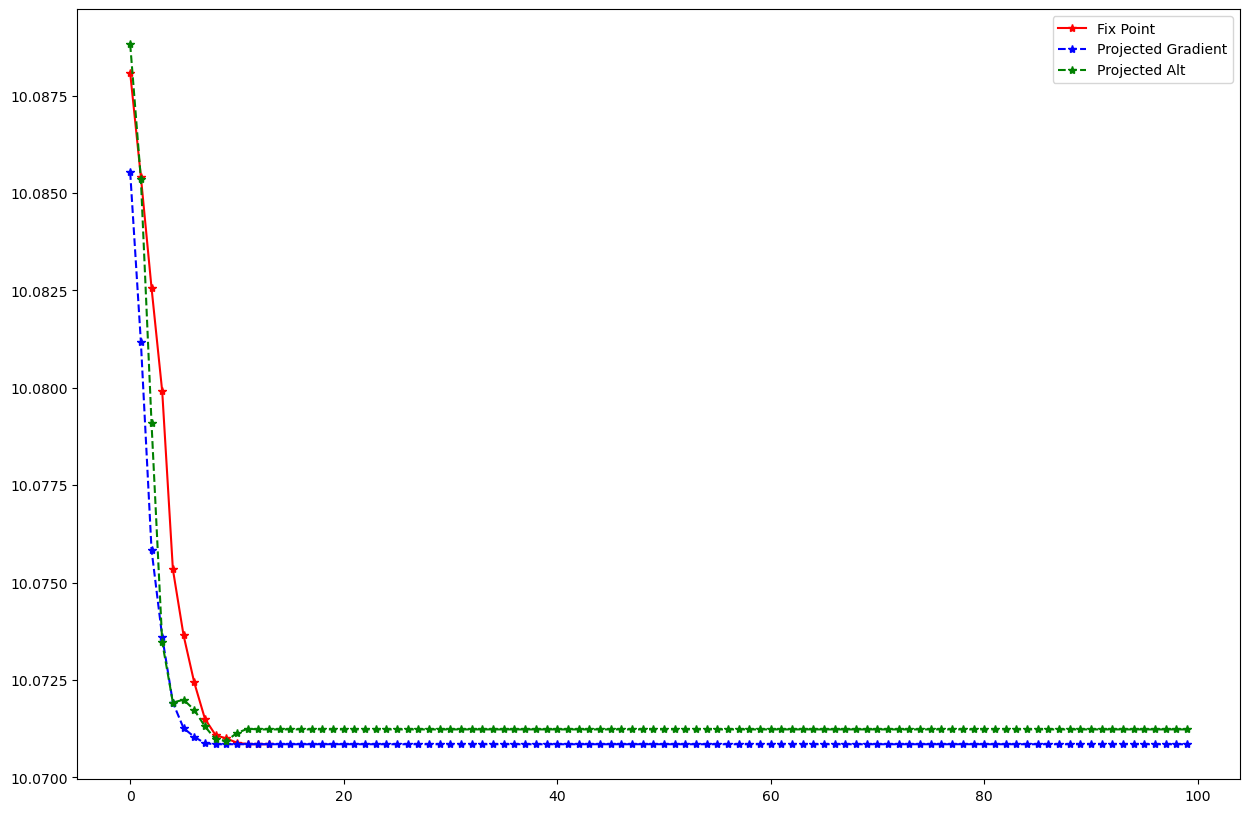

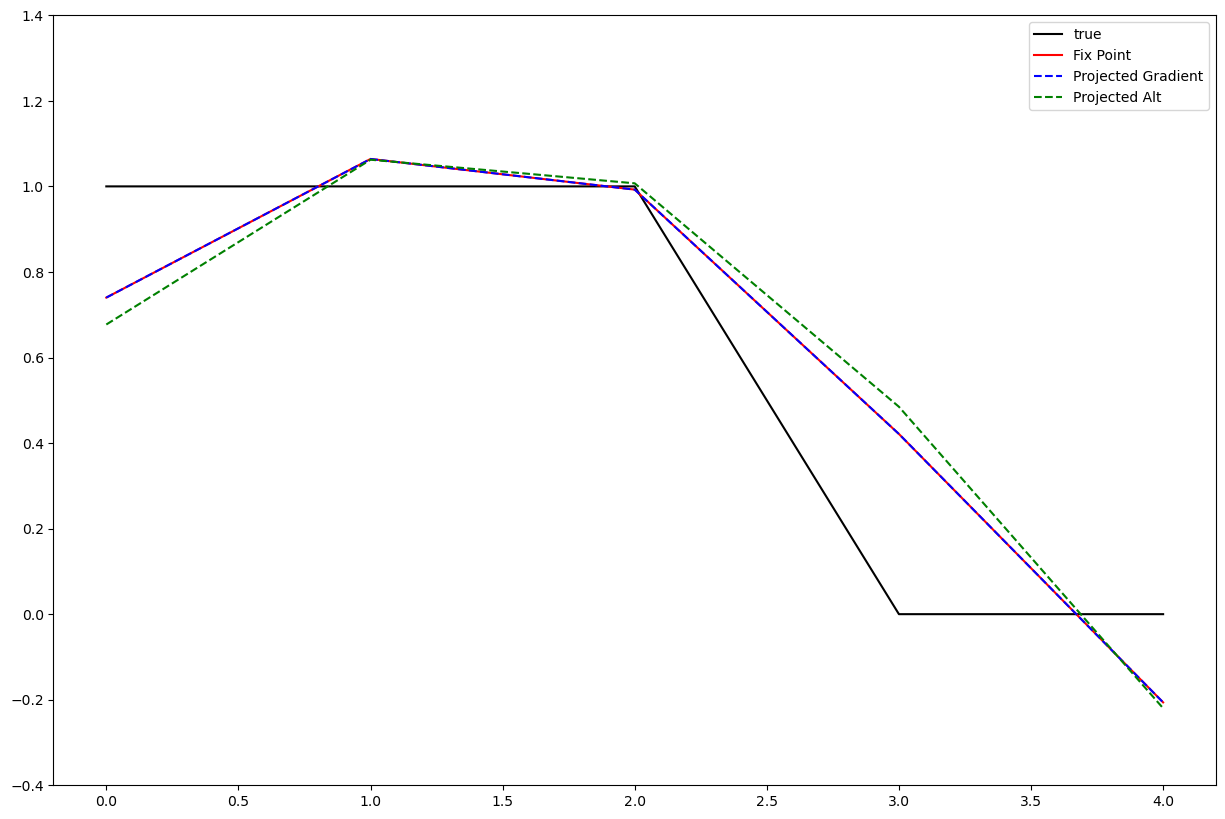

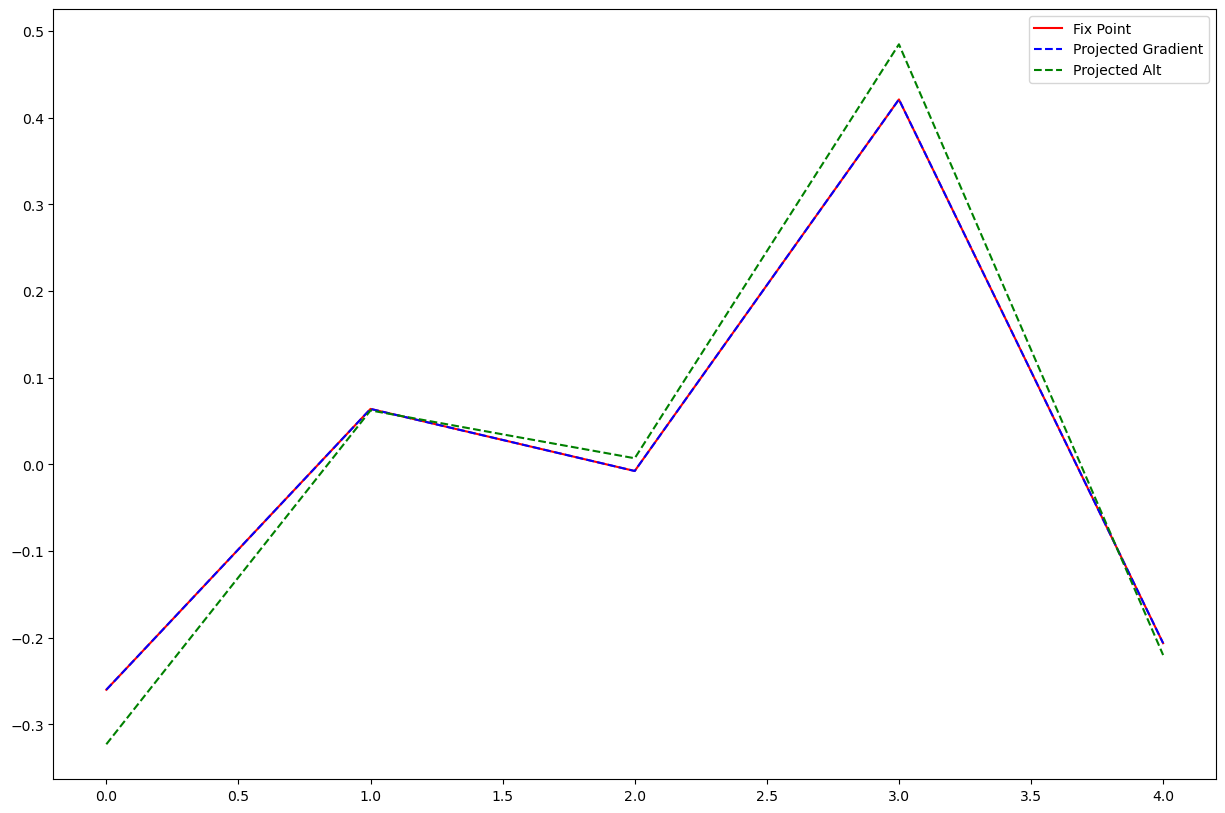

In [6]:
xs = [x_fp, x_pg, x_pn]
print(x_fp)
names = ['Fix Point', 'Projected Gradient', 'Projected Alt']
losses = [losses_fp, losses_pg, losses_pn]
linestyles = ['r-', 'b--', 'g--']

plt.figure(1, figsize=(15,10))
plt.figure(2, figsize=(15,10))
plt.plot(x, 'k', label='true')
plt.figure(3, figsize=(15,10))

for xi, li, ni, ls in zip(xs, losses, names, linestyles):
    x_al = align(fft(x), fft(xi)[None, :], xi[None, :])[0].real
    
    print(f"{ni}: {np.linalg.norm(x - x_al)/np.linalg.norm(x)}")
    
    plt.figure(1)
    plt.plot(li, ls + '*', label=ni)    

    plt.figure(2)
    plt.plot(x_al, ls, label=ni)
    
    plt.figure(3)
    plt.plot(x_al-x, ls, label=ni)

plt.figure(1)
plt.legend()

plt.figure(2)
plt.legend()
plt.ylim([min(x)-0.4, max(x)+0.4])

plt.figure(3)
plt.legend()



### Signal size 5

Below code only works for signal size 5

In [7]:
from multiprocessing import Pool, cpu_count

xfft_abs_apx = acf_fft ** 0.5

def get_angles(signal):
    fft_sig = np.fft.fft(signal)
    return np.angle(fft_sig[4]), np.angle(fft_sig[3])

def get_angles_2(signal, delta): # Project angles to tangent plane
    fft_sig = np.fft.fft(signal)
    fft_del = np.fft.fft(delta)
    ratio = (fft_del/fft_sig)
    return ratio[4].imag, ratio[3].imag

def create_signal(angle1, angle2):
    e1 = np.exp(1j * angle1)
    e2 = np.exp(1j * angle2)
    return np.array([mean,
     e1 * xfft_abs_apx[1],
     e2 * xfft_abs_apx[2],
     e2.conj() * xfft_abs_apx[3],
     e1.conj() * xfft_abs_apx[4]])
    
    
def find_shifts_np(xfft, yfft):
    return jnp.argmax(np.fft.ifft(xfft * yfft.conj(), axis=1).real, axis=1)


def align_np(xfft, yfft, y):
    shift_rec = find_shifts_np(xfft, yfft)
    y_shift = jnp.vstack([np.roll(y_i, s_i) for y_i, s_i in zip(y, shift_rec)])
    return y_shift


def loss_np(xfft, yfft, y):
    y_shift = align_np(xfft, yfft, y)
    return np.mean((y_shift - ifft(xfft))**2).real
    
angle1s, angle2s = np.meshgrid(np.linspace(0, 2*np.pi, 50), np.linspace(0, 2*np.pi, 50))

def loss_map(args):
    a1, a2 = args[0], args[1]
    return loss_np(create_signal(a1, a2), yfft, y)

def to_tangent_plane(vector, normal):
    return vector - np.dot(vector, normal) * normal / np.linalg.norm(normal)**2

def cosine_similarity(f, g):
    return np.dot(f, g) / np.linalg.norm(f) / np.linalg.norm(g)

def alignment_map(args):
    a1, a2 = args[0], args[1]
    x = ifft(create_signal(a1, a2)).real
    f = ifft(jnp.conjugate(grad_loss(fft(x), yfft, y))).real
    g = grad_loss_new(x, yfft, y)
    return cosine_similarity(to_tangent_plane(f, x), to_tangent_plane(g, x))

def get_angles_map(args, grad_setting=1):
    a1, a2 = args[0], args[1]
    x = ifft(create_signal(a1, a2))
    
    if grad_setting == 0:
        f = ifft(jnp.conjugate(grad_loss(fft(x), yfft, y)))
    else:
        f = grad_loss_new(x, yfft, y)
    
    #dt = 0.001
    #a11, a21 = get_angles(x + dt * f)
    #a12, a22 = get_angles(x)
    a1, a2 = get_angles_2(x, f)
    #a1 = ((a11 - a12)/dt)# % (2*np.pi)
    #a2 = ((a21 - a22)/dt)# % (2*np.pi)
    #length = np.linalg.norm([a1, a2])
    #return np.sin(a1), np.sin(a2)
    return np.array([a1, a2]) #/ length
    

def amap0(args):
    return get_angles_map(args, 0)

def amap1(args):
    return get_angles_map(args, 1)


In [8]:
pool = Pool(50)
losses = np.array(pool.map(loss_map, zip(angle1s.flatten(), angle2s.flatten()))).reshape(*angle1s.shape)
aligns = np.array(pool.map(alignment_map, zip(angle1s.flatten(), angle2s.flatten()))).reshape(*angle1s.shape)
grads0 = np.array(pool.map(amap0, zip(angle1s.flatten(), angle2s.flatten()))).reshape(*angle1s.shape, -1)
grads1 = np.array(pool.map(amap1, zip(angle1s.flatten(), angle2s.flatten()))).reshape(*angle1s.shape, -1)
#losses = np.array([find_loss(ifft(create_signal(a1, a2)), yfft, y) for a1, a2 in zip(angle1s.flatten(), angle2s.flatten())]).reshape(*angle1s.shape)
#losses = np.array([loss_map((a1, a2)) for a1, a2 in zip(angle1s.flatten(), angle2s.flatten())]).reshape(*angle1s.shape)
#find_loss(x, yfft, y)

Fix Point:(4.173571922431833, 5.42522413181189)
Projected Gradient:(4.173571867415878, 5.42522449661304)
Projected Alt:(4.2588848704729205, 5.539112162622861)


(4.539112162622861, 6.539112162622861)

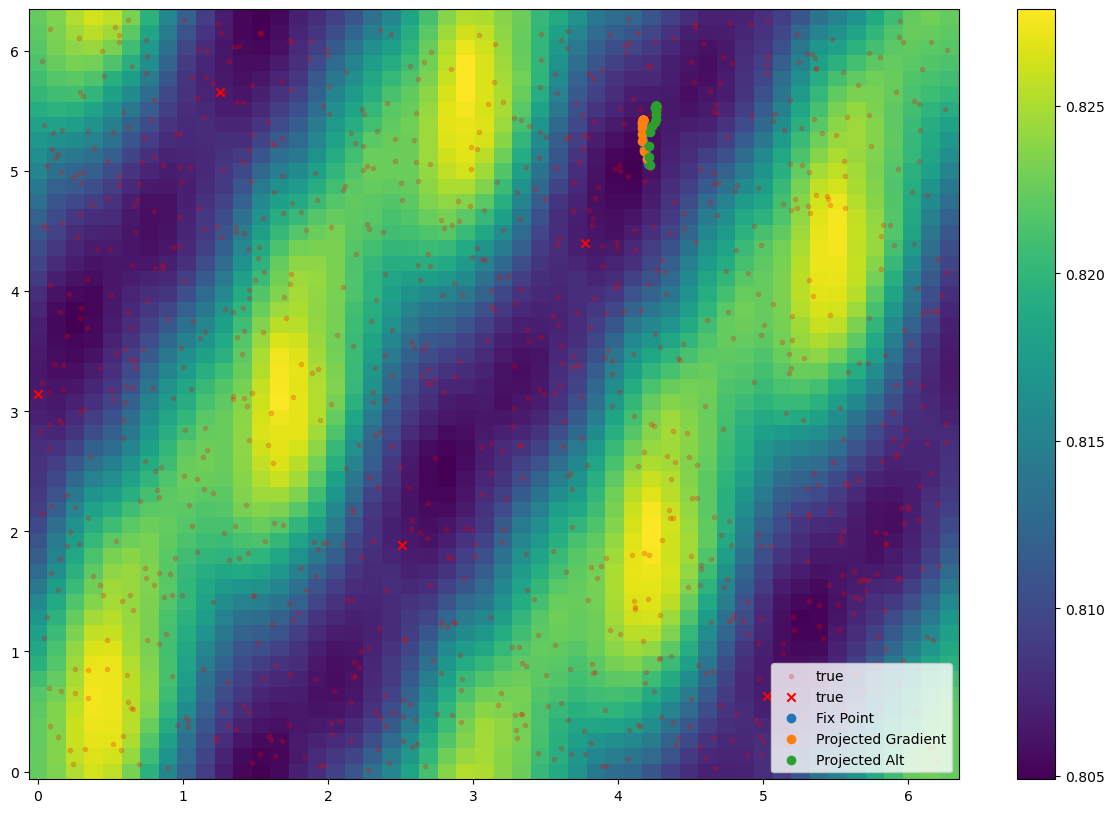

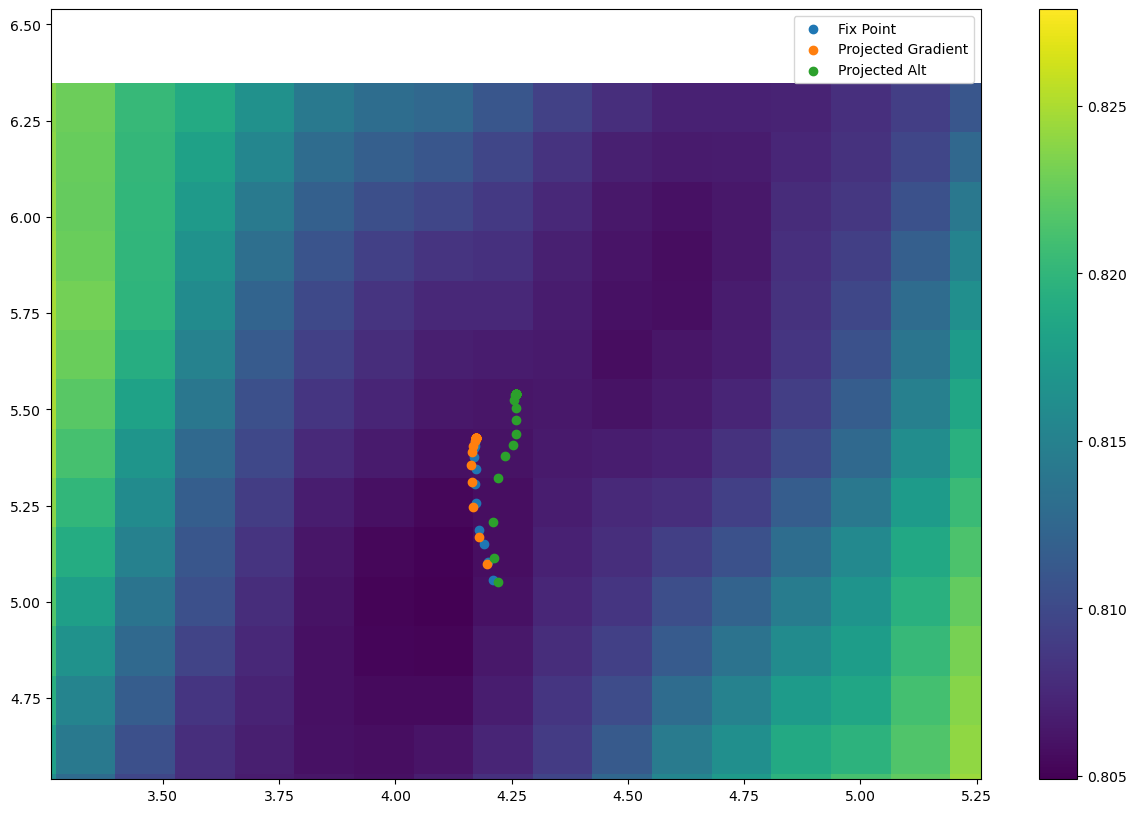

In [9]:
plt.figure(figsize=(15,10))

angle_data = np.array([np.array(get_angles(yi)) for yi in y])


plt.pcolormesh(angle1s, angle2s, losses.real)
plt.colorbar()
#plt.hist2d(angle_data[:, 0] % (2*np.pi), angle_data[:, 1] % (2*np.pi), bins=5, alpha=0.5)
plt.scatter(angle_data[:, 0] % (2*np.pi), angle_data[:, 1] % (2*np.pi), c='r', marker='.', label='true', alpha=0.2)


for s in range(5):
    x_roll = np.roll(x, s)
    angle1, angle2 = get_angles(x_roll)
    plt.scatter(angle1 % (2*np.pi), angle2 % (2*np.pi), c='r', marker='x', label='true' if s==0 else None)

for iter_i, n_i, ls_i in zip([iter_fp, iter_pg, iter_pn], names, linestyles):
    angles = [get_angles(ifft(xfft)) for xfft in iter_i]
    angle0 = np.array([a[0] for a in angles]) % (2*np.pi)
    angle1 = np.array([a[1] for a in angles]) % (2*np.pi)
    #plt.plot(angle0, angle1, ls_i, label=n_i)
    plt.scatter(angle0, angle1, label=n_i)


plt.legend()

plt.figure(figsize=(15,10))
plt.pcolormesh(angle1s, angle2s, losses.real)
plt.colorbar()
for s in range(5):
    x_roll = np.roll(x, s)
    angle1, angle2 = get_angles(x_roll)
    plt.scatter(angle1 % (2*np.pi), angle2 % (2*np.pi), c='r')

#max_
angs = []
for iter_i, n_i, ls_i in zip([iter_fp, iter_pg, iter_pn], names, linestyles):
    angles = [get_angles(ifft(xfft)) for xfft in iter_i]
    angle0 = np.array([a[0] for a in angles]) % (2*np.pi)
    angle1 = np.array([a[1] for a in angles]) % (2*np.pi)
    
    print(f"{n_i}:{angle0[-1], angle1[-1]}")
    #max_a0, min_a0 = max(max(angle0), max_a0), min(min(angle0), min_a0)
    angs.append((angle0[-1], angle1[-1]))
    #plt.plot(angle0, angle1, ls_i, label=n_i)
    plt.scatter(angle0, angle1, label=n_i)

plt.legend()
plt.xlim([angle0[-1]-1, angle0[-1]+1])
plt.ylim([angle1[-1]-1, angle1[-1]+1])

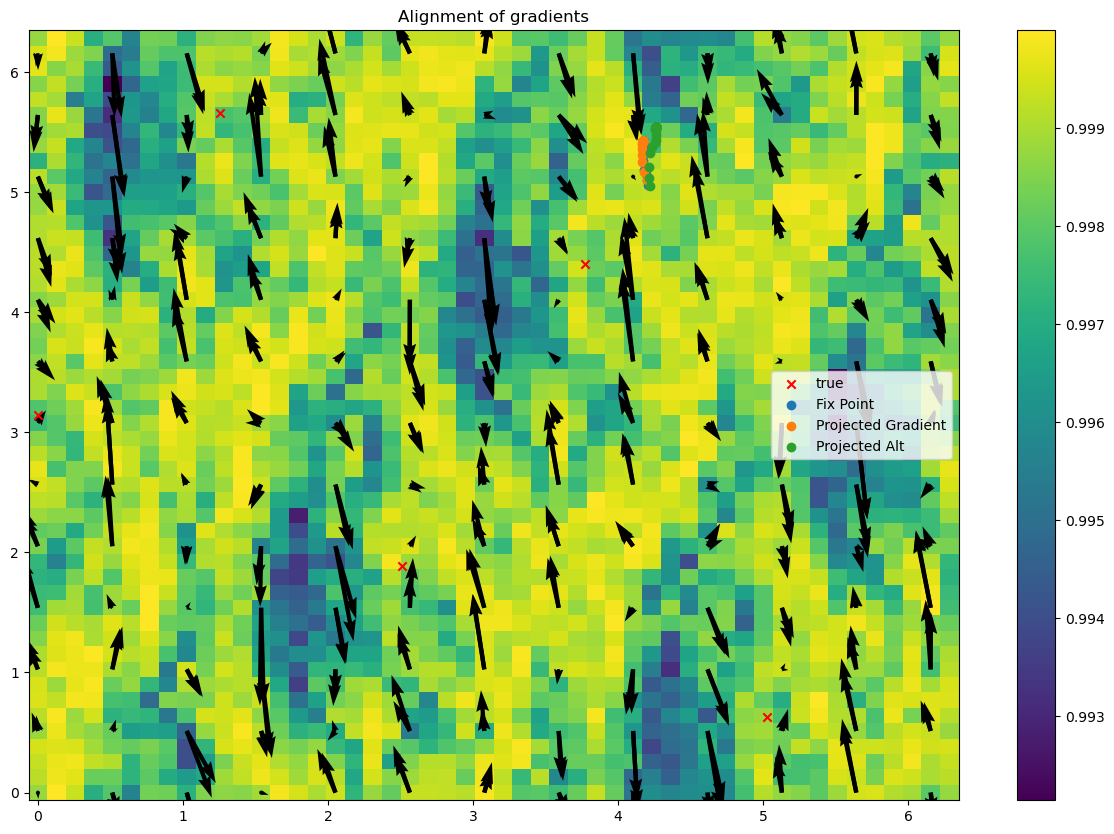

In [10]:
plt.figure(figsize=(15,10))
plt.pcolormesh(angle1s, angle2s, aligns.real, cmap="viridis")#losses.real)
plt.colorbar()
#plt.pcolormesh(angle1s, angle2s, gradis[:,:,0]**2 + gradis[:,:,1]**2)


m = 4 # Downsample for quiver
plt.quiver(angle1s[::m, ::m].flatten(), 
           angle2s[::m, ::m].flatten(), 
           grads0[::m,::m,0].flatten(), 
           grads0[::m,::m,1].flatten())

plt.quiver(angle1s[::m, ::m].flatten(), 
           angle2s[::m, ::m].flatten(), 
           grads1[::m,::m,0].flatten(), 
           grads1[::m,::m,1].flatten())

plt.title("Alignment of gradients")

for s in range(5):
    x_roll = np.roll(x, s)
    angle1, angle2 = get_angles(x_roll)
    plt.scatter(angle1 % (2*np.pi), angle2 % (2*np.pi), c='r', marker='x', label='true' if s==0 else None)

for iter_i, n_i, ls_i in zip([iter_fp, iter_pg, iter_pn], names, linestyles):
    angles = [get_angles(ifft(xfft)) for xfft in iter_i]
    angle0 = np.array([a[0] for a in angles]) % (2*np.pi)
    angle1 = np.array([a[1] for a in angles]) % (2*np.pi)
    #plt.plot(angle0, angle1, ls_i, label=n_i)
    plt.scatter(angle0, angle1, label=n_i)
    


plt.legend()



### Projection onto tangent plane.
We have 
$$
    f_k + \epsilon g_k = r_j \exp(i\alpha_j+i2\pi kj) + \epsilon s_j \exp(i\beta_j + u2\pi kj) 
$$
After simplifying,
$$
    = r_j\exp(i\alpha_j)\left(1 + \epsilon\tfrac{r_j}{s_j}\exp(i(\beta_j - \alpha_j))\right) = r_j\exp(i\alpha_j)\exp\left[\epsilon\tfrac{r_j}{s_j}\exp(i(\beta_j-\alpha_j))\right] + \mathcal{O}(\epsilon^2)
$$
Which can be rewritten as
$$
    r_j\exp(i\alpha_j)\exp\left[\mathrm{Re}(\tfrac{\hat g_j}{\hat f_j}) + i\mathrm{Im}(\tfrac{\hat g_j}{\hat f_j})\right] = r_j\exp\left(\epsilon\mathrm{Re}(\tfrac{\hat g_j}{\hat f_j})\right)\exp\left(i(\alpha_j + \epsilon\mathrm{Im}(\tfrac{\hat g_j}{\hat f_j})\right) 
$$